# Machine Learning with scikit-learn

Sometimes the features you have available in your initial data have little predictive strength when used in the most straightforward way.  This might be true almost regardless of choice of model class and hyperparameters.  And yet it might also be true that there are synthetic features latent in the data that are highly predictive, but that have to be *engineered* (mechanically, rather than sample-wise modification) to produce powerful features.

At the same time, a highly dimension model—whether of high dimension because of the initial data collection or because of creation of extra synthetic features—may lend itself less well to modeling techniques.  In these cases, it can be more computationally tractable, as well as more predictive, to work with a subset of all available features.

In [58]:
# Some libraries tend to be in flux for their dependency versions
import warnings
warnings.simplefilter("ignore")

# We utilize some mglearn demo functions
import src.mglearn as mglearn

### A synthetic example

Let us look at an artificial example where raw features of a dataset of absolutely no value, but it is possible to derive good predictions by creating syntheric features out of them.  Obviously, real world data will not be as neat as that, but it is useful to express the concept.

At first brush the loaded data seems fairly noisy without an obvious pattern.

In [34]:
import pandas as pd
linf = pd.read_csv('data/linear_failure.csv', index_col=0)
linf.head()

,feature_1,feature_2,TARGET
0,0.162275,-0.282523,-0.045846
1,-0.874404,-0.164955,0.144237
2,0.000540,0.751708,0.000406
3,0.721775,-0.246271,-0.177752
4,0.374113,0.283637,0.106112


In [35]:
# The features seem uncorrelated, and no univariate correlation with target
linf.corr()

,feature_1,feature_2,TARGET
feature_1,1.000000,-0.006995,0.033990
feature_2,-0.006995,1.000000,-0.031077
TARGET,0.033990,-0.031077,1.000000


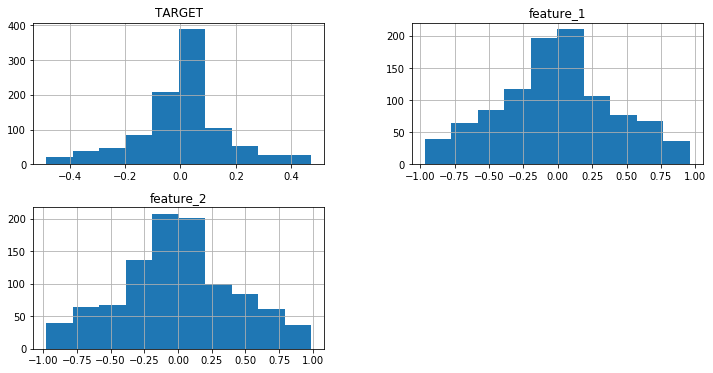

In [36]:
# Distribution of features and target looks roughly Gaussian
linf.hist(figsize=(12,6));

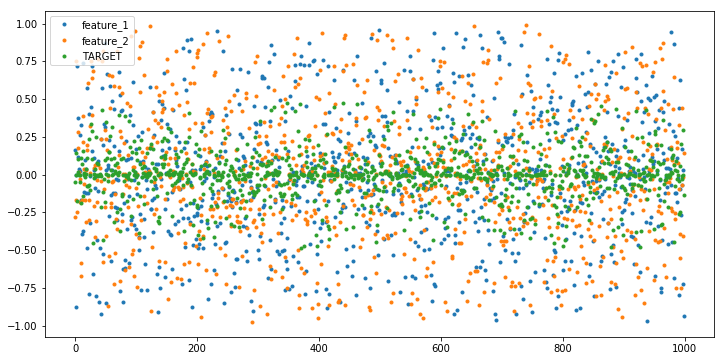

In [37]:
# No obvious trends in the data as sequences
%matplotlib inline
linf.plot(figsize=(12,6), style='.');

We might hope to identify a relationship between features and target using a linear regression such as this:

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = linf.drop('TARGET', axis=1)
y = linf['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

-0.0077727014623785165

Slightly different linear models do equally poorly in detecting any relationship between the features and the target.  Notice that the metric used here is $R^2$ score rather than e.g. explained variance or mean absolute error (or others).


In [39]:
from sklearn.linear_model import Lasso, Ridge
lasso, ridge = Lasso(), Ridge()
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

lasso.score(X_test, y_test), ridge.score(X_test, y_test)

(-0.0035696498877093585, -0.007721881351163473)

### Adding a feature

Let us try creating a new feature that is entirely based on existing features.

In [45]:
linf['f1xf2'] = linf.feature_1 * linf.feature_2
linf.head()

,feature_1,feature_2,TARGET,f1xf2
0,0.162275,-0.282523,-0.045846,-0.045846
1,-0.874404,-0.164955,0.144237,0.144237
2,0.000540,0.751708,0.000406,0.000406
3,0.721775,-0.246271,-0.177752,-0.177752
4,0.374113,0.283637,0.106112,0.106112


In [42]:
X = linf.drop('TARGET', axis=1)
y = linf['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

1.0

The information we need was "latent" in the data the whole time, it just needed to be teased out.

In fairness, we can note that other regressors manage to derive the synthetic feature through their algorithmic structure.  But these regressors will have their own "blind spots" also, relative to different datasets.

In [43]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.9997914313708574

In [44]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.9729453267239967

## Dimensionality reduction

There are two general approaches to *reducing* the number of dimensions (i.e. features) in a dataset.  One is by creating synthetic features that globally combine the raw features.  Several different mathematical techniques are available for doing this.

The other means by which we might reduce dimensions is simply by discarding ones that seem to have little significance to the model.  Very often models actually perform *better* by removing features that are either purely independent of the target or are largely redundant with other features (i.e. highly correlated).  In every case, models can be trained *faster* with fewer dimensions.

PCA is the oldest and most widely used method for decomposition of dimensional information.  Other methods of decomposition are also provided by scikit-learn.  In broad concept they do something similar, but each shows strengths relative to different datasets; understanding the difference is a mixture of domain familiarity and trial-and-error.

### Miscellaneous decompositions

This lesson will not specifically discuss all of the decomposition classes available in `sklearn.decomposition`.  A complete list with brief descriptions from the [documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) is below.  The discussion and examples of reconstructed faces in the [user guide](http://scikit-learn.org/stable/modules/decomposition.html) is very useful.

| Class name          | Description
|---------------------|------------------------------------
| DictionaryLearning  | Dictionary learning
| FactorAnalysis      | Factor Analysis (FA)
| FastICA             | FastICA: a fast algorithm for Independent Component Analysis.
| IncrementalPCA      | Incremental principal components analysis (IPCA).
| KernelPCA           | Kernel Principal component analysis (KPCA)
| LatentDirichletAllocation | Latent Dirichlet Allocation with online variational Bayes algorithm
| MiniBatchDictionaryLearning | Mini-batch dictionary learning
| MiniBatchSparsePCA  | Mini-batch Sparse Principal Components Analysis
| NMF                 | Non-Negative Matrix Factorization (NMF)
| PCA                 | Principal component analysis (PCA)
| SparsePCA           | Sparse Principal Components Analysis (SparsePCA)
| SparseCoder         | Sparse coding
| TruncatedSVD        | Dimensionality reduction using truncated SVD (aka LSA).
| dict_learning       | Solves a dictionary learning matrix factorization problem.
| dict_learning_online| Solves a dictionary learning matrix factorization problem online.
| fastica             | Perform Fast Independent Component Analysis.
| sparse_encode       | Sparse coding


### Principal component analysis (PCA)

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The transformation is defined in such a way that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

Let us look at an example. We will choose the Wisconsin breast cancer dataset we worked with in a previous lesson.  Recall that it has 30 features measuring a variety of numeric medical diagnostic results.

First thing, we load the dataset and apply standard scaling to the features.  Later in this lesson we will talk more about scaling, and we have brushed on it in a few previous lessons.

In [53]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

Perform a standard train/test split as we have with almost all models.

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, cancer.target, random_state=1)

For pending comparison, let us remind ourselves of how the raw data preforms using two classifers: `LinearRegression` and `KNeighborsClassifier`.

In [61]:
from sklearn.linear_model import LinearRegression
(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.7222686011972144

In [62]:
from sklearn.neighbors import KNeighborsClassifier
(KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.951048951048951

Now we transform the parametric space of the features into just two dimensions that contain the maximum amount of information that **can be** represented in two dimensions.

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: %s" % str(X_scaled.shape))
print("Reduced shape: %s" % str(X_pca.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


Looking at a scatter plot, we can see that just two dimensions already get rather good differentiation visually.  Notice that these two components each represent an arbitrary combination of all the actual observational measurements in the dataset.  Therefore, they do not have any obvious English description other than "first component" and "second component."

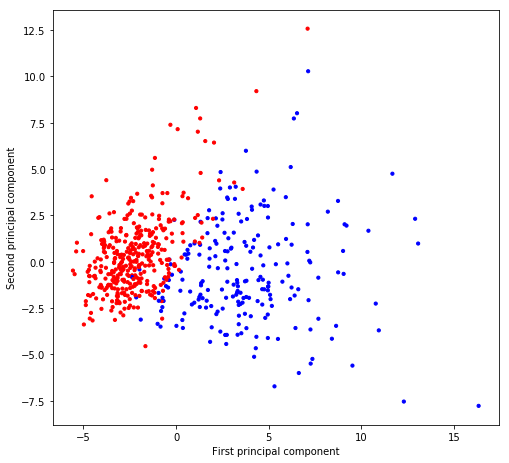

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

With just two components retained, the linear regression performs a bit worse, but KNN (that is much stronger so far for this data, in any case), performs basically equally well as with all 30 dimensions.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, cancer.target, random_state=1)

In [65]:
(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.6279864206554091

In [66]:
(KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.9440559440559441

We can see how the two PCA components are derived by linear combination of the original 30.

In [68]:
print(pca.components_)

[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Or more visually (but only some original features shown for legibility):

<Figure size 1440x1080 with 0 Axes>

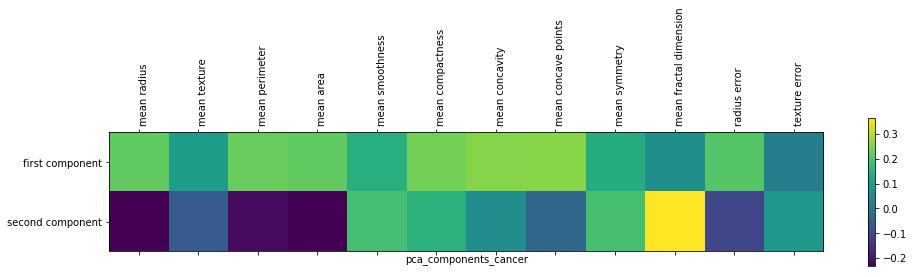

In [71]:
# Not all original features shown...
nfeat = 12
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat),
           cancer.feature_names[:nfeat], rotation=90, ha='left');
plt.xlabel("pca_components_cancer");

### Rotation, sphering and whitening

This course will not have time to address it, but additional preprocessing steps such as subtracting off the mean or calculating a z-score `(X-X.mean())/X.std()` can improve the fit of a PCA model.  The `PCA` class has options for some of these operations built in.

### Non-negative matrix factorization (NMF)

NMF finds two non-negative matrices whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [73]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
nmf.fit(cancer.data)
X_nmf = pca.transform(cancer.data)
print("Original shape: %s" % str(cancer.data.shape))
print("Reduced shape: %s" % str(X_pca.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


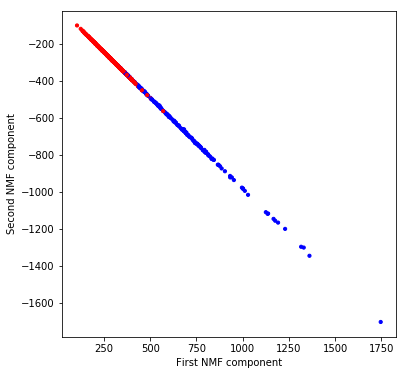

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(6, 6))
plt.scatter(X_nmf[:, 0], X_nmf[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First NMF component")
plt.ylabel("Second NMF component");

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X_nmf, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.51335911567084
0.8531468531468531


### Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.

This Bayesian technique has proven very useful for identifing hidden unobserved features in textual data sources.  It is not particularly well suited to the kind of numeric data we see in the cancer dataset, but we use that simply to show API usage here. Basically, it is the same as other decomposition classes—and generally the same as all the models throughout scikit-learn.

In [89]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=2)
lda.fit(cancer.data)
X_lda = lda.transform(cancer.data)
print("Original shape: %s" % str(cancer.data.shape))
print("Reduced shape: %s" % str(X_lda.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


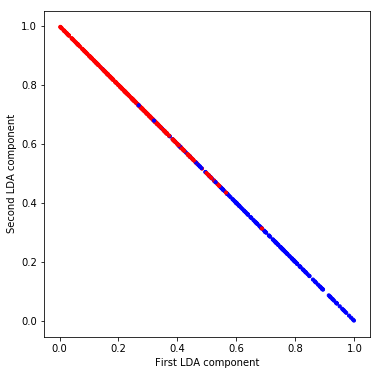

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(6, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First LDA component")
plt.ylabel("Second LDA component");

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.5741463988915751
0.9090909090909091


### Independent component analysis (ICA)

Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is implemented in scikit-learn using the Fast ICA algorithm. Typically, ICA is not used for reducing dimensionality but for separating superimposed signals. 

> In PCA the basis you want to find is the one that best explains the variability of your data. The first vector of the PCA basis is the one that best explains the variability of your data (the principal direction) the second vector is the 2nd best explanation and must be orthogonal to the first one.

> In ICA the basis you want to find is the one in which each vector is an independent component of your data, you can think of your data as a mix of signals and then the ICA basis will have a vector for each independent signal.

> In a more practical way we can say that PCA helps when you want to find a reduced-rank representation of your data and ICA helps when you want to find a representation of your data as independent sub-elements. In layman terms PCA helps to compress data and ICA helps to separate data.

Quote credit: [Luis Argerich](https://www.quora.com/What-is-the-difference-between-PCA-and-ICA), Data Science Professor at the University of Buenos Aires (UBA)

In [95]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
ica.fit(cancer.data)
X_ica = ica.transform(cancer.data)
print("Original shape: %s" % str(cancer.data.shape))
print("Reduced shape: %s" % str(X_ica.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


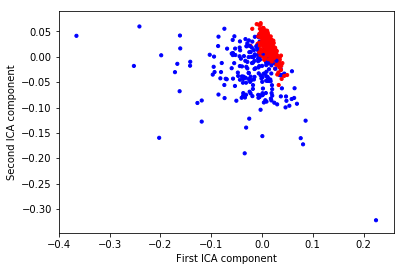

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(6, 6))
plt.scatter(X_ica[:, 0], X_ica[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First ICA component")
plt.ylabel("Second ICA component");

One might hope that since ICA is often used for separation of "signals" in noisy data, the cancer data might do better than PCA at detecting the "benign" and "malignant" signals that might be reflected in the indirect medical measurements.

At least without other parameterization, or other models, and looking at exactly two components, ICA does moderately worse than PCA.  Only very slightly so though; it is possible that other feature engineering might allow ICA to emerge as a good technicque for this problem area. 

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ica, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.48826561832822657
0.9370629370629371


### t-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

That is to say, t-SNE can often help models in similar ways to what PCA, NMF, LDA, or ICA do.  But it also is especially useful to create low-dimensional representations (i.e. two dimensions can actually fit on your computer monitors or printed books).

An example that shows t-SNE well is the digit dataset that we saw in an earlier lesson.  Let us load that data, and decompose it with both PCA and t-SNE.

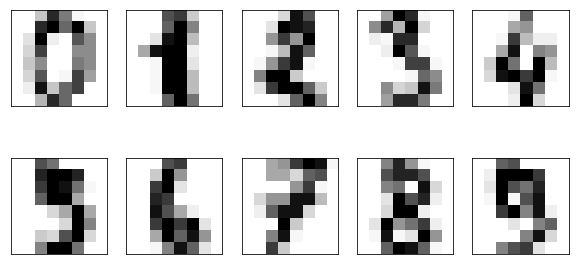

In [79]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img, cmap=plt.get_cmap('Greys'))

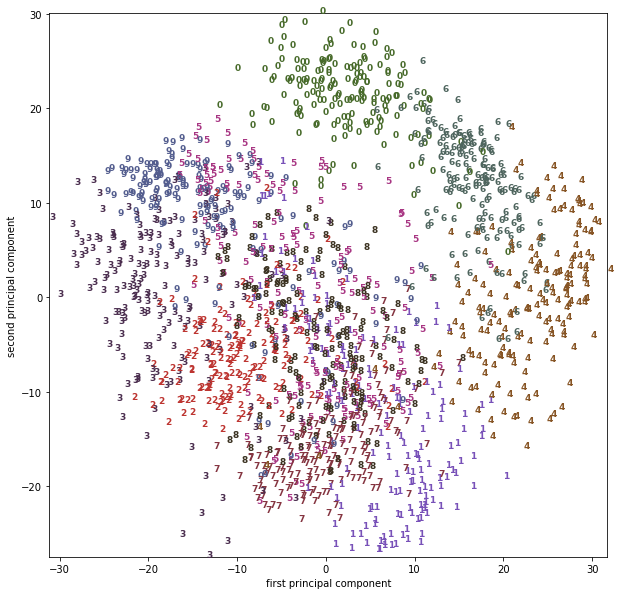

In [80]:
# build a PCA model
pca = PCA(n_components=2)
pca.fit(digits.data)

# transform the digits data onto the first two principal components
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120","#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("first principal component")
plt.ylabel("second principal component");

In [81]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method:
digits_tsne = tsne.fit_transform(digits.data)

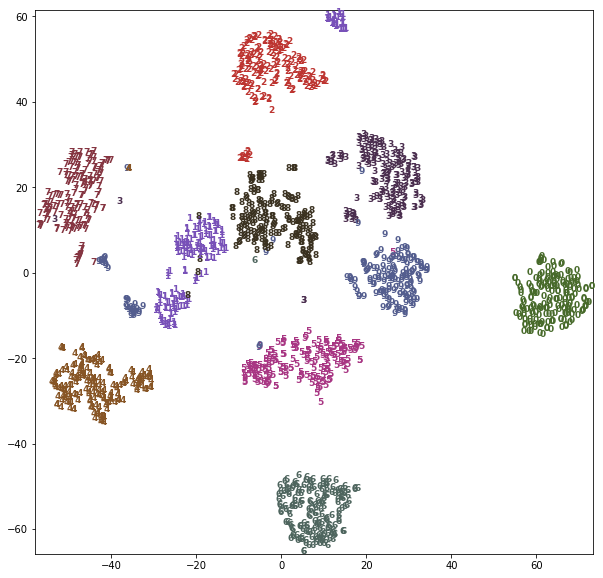

In [82]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

## Feature Selection

One way to reduce features in a dataset is to throw some of them away.  In principle, features thrown away can be engineered features such as those resulting from decompositions or those discussed below that are combined or synthesized from raw features.  Scikit-learn gives you several ways to choose features to discard; or euqivalently, features to keep.

There are several univariate feature selectors in scikit-learn.  `SelectKBest` is essentially the same as `SelectPercentile`, merely different in whether you indicate a number of percentage of features to keep.  Obviously, it is easy to derive one from the other based on number of features in the raw data. Just slightly different are false positive rate (`SelectFpr`), false discovery rate (`SelectFdr`), or family wise error (`SelectFwe`).  

All of these let you specify a scoring function the judges the quality of the estimate using just one feature.  For regression, there are `f_regression`, `mutual_info_regression`; for classification: `chi2`, `f_classif`, `mutual_info_classif`.  You can also, in principle, use a custom function to evaluate strength of a single feature for prediction.

### Univariate

Let us look at the Wisconsin cancer dataset from perspective of simply identifying the most important features (in the raw dataset).  Notice that we use the entire dataset for this purpose, not only a training portion of it.

In [116]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=5)
X_new = selector.fit_transform(cancer.data, cancer.target)
cancer.data.shape, X_new.shape

((569, 30), (569, 5))

In [130]:
kbest = pd.Series(selector.scores_, index=cancer.feature_names).sort_values(ascending=False)
kbest.head(10)

worst area         112598.431564
mean area           53991.655924
area error           8758.504705
worst perimeter      3665.035416
mean perimeter       2011.102864
worst radius          491.689157
mean radius           266.104917
perimeter error       250.571896
worst texture         174.449400
mean texture           93.897508
dtype: float64

Let us take a look at how models work with all 30 features versus with just the top 5 in a univariate filter.  In this example, we do not get better with this step alone (but KNN doesn't get much worse), but in some cases the score will actually improve without surpul dimensions.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.722268601197215
0.9370629370629371


In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.5857835011372032
0.9230769230769231


### Model-based Feature Selection

A number of selectors are based on the chosen underlying model itself rather on univariate strengths of features.  This only works with models than expose a `.coef_` or `.feature_importances_` attribute on a trained model.  Not all algorithms allow the determination of those values.

We look here at recursive feature elimnation which is based on a model, and arrives at the most important features by eliminating the least important, then refitting based on those that remain, and doing so repeatedly until only the number of features requested remain.  The selector `SelectFromModel` works in a similar way, but recursive selection will generally be better quality (albeit slower since it involves repeated refitting).

In [131]:
# Recursive feature elimination
from sklearn.feature_selection import RFE

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=5, step=1)
rfe.fit(cancer.data, cancer.target)

pd.Series(rfe.ranking_, index=cancer.feature_names).sort_values(ascending=False).head(10)

mean area            26
worst area           25
mean texture         24
area error           23
worst perimeter      22
texture error        21
worst texture        20
worst compactness    19
mean perimeter       18
mean radius          17
dtype: int64

The relative importance of features is similar, but somewhat different under recursive feature elimination than under k-best selection.  Given the nature of linear models, we mostly expect univariate elimination to behave similarly to recursive elimination based on linear regression.  Something like a decision tree (which provides `.feature_importances_`) might have a more different ranking of selected features.

We can go farther here and use `RFECV` to recursive eliminate features, cross-validate the model at each stage, and keep a record of the relationship between model score and number of features.

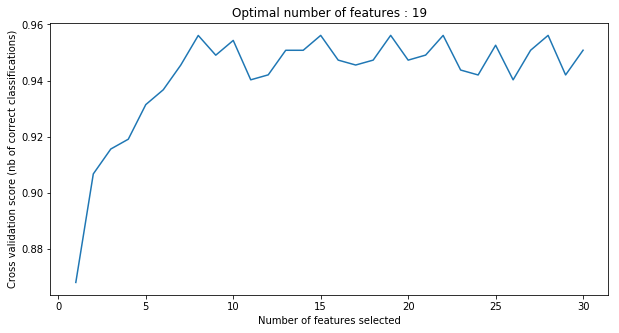

In [145]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

rf = RandomForestClassifier(max_depth=7, random_state=1)
rfecv = RFECV(estimator=rf)
rfecv.fit(cancer.data, cancer.target)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()

## Dimensionality Expansion

There are two standard ways in which you are likely to engineer new synthetic features based on existing features: polynomial features and one-hot encoding.  In a sense, the decompositions also do the same thing—but they create synthetic features globally across the parametric space, and they generally are used as replacements rather than supplements to raw features.

### Polynomial Features

Generating polynomial features will create a very large number of new features.  The basic idea is simple, we add new features that are the multiplicative product of up to degree=N of the existing features.  In the toy example at the beginning of this lesson, we manually synthesized one feature by multiplying two existing ones together.  The `PolyFeatures` construction does so with all combinations of parameters.

Often using polynomial features is a large part of the reason it is particularly important to go back and winnow features using feature selection.  Reducing 30 features to 19 in the above example is unlikely to be hugely important to most models.  But reducing the 496 synthetic features in the below example becomes important (let alone the much larger number if you choose a higher degree or started with more raw features).

If the `interactions_only` option is not used, the number of produced features is:

$$ \#Features = N + N + \frac{N \times (N-1)}{2} + 1 $$

E.g. for degree=30, it is 496; for degree=100, it is 5151.

In [152]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(cancer.data)
cancer.data.shape, X_poly.shape

((569, 30), (569, 496))

In [156]:
poly_names = poly.get_feature_names(cancer.feature_names)
pd.DataFrame(X_poly, columns=poly_names).head()

,1,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst concavity^2,worst concavity worst concave points,worst concavity worst symmetry,worst concavity worst fractal dimension,worst concave points^2,worst concave points worst symmetry,worst concave points worst fractal dimension,worst symmetry^2,worst symmetry worst fractal dimension,worst fractal dimension^2
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.506802,0.188938,0.327545,0.084645,0.070437,0.122111,0.031556,0.211692,0.054706,0.014137
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.058371,0.044938,0.066440,0.021507,0.034596,0.051150,0.016558,0.075625,0.024481,0.007925
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.202860,0.109447,0.162730,0.039446,0.059049,0.087796,0.021282,0.130538,0.031643,0.007670
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.471832,0.176877,0.455964,0.118834,0.066306,0.170928,0.044547,0.440630,0.114837,0.029929
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.160000,0.065000,0.094560,0.030712,0.026406,0.038415,0.012477,0.055885,0.018151,0.005895


In [167]:
rfc = RandomForestClassifier(max_depth=7, random_state=1)
rfe = RFE(estimator=rfc, n_features_to_select=50, step=1)

X_poly_top = rfe.fit_transform(X_poly, cancer.target)
X_poly_top.shape

(569, 50)

In [166]:
pd.Series(rfe.ranking_, index=poly_names).sort_values(ascending=False).head(15)

1                                        447
mean radius                              446
mean symmetry area error                 445
mean texture                             444
mean perimeter                           443
mean area                                442
mean smoothness                          441
mean compactness                         440
mean concavity                           439
mean concave points                      438
mean symmetry                            437
mean fractal dimension                   436
radius error                             435
texture error                            434
mean symmetry fractal dimension error    433
dtype: int64

In [228]:
# Scale the engineered features (makes little difference for this model, but is good practice)
X_poly_top_scaled = StandardScaler().fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(
    X_poly_top_scaled, cancer.target, random_state=42)

rfc.fit(X_train, y_train).score(X_test, y_test)

0.9790209790209791

### One-Hot Encoding

We have looked in previous lessons at the need to encode categorical values in **one-hot encoding**.  That is, we might have one feature with a a number of class values encoded in it.  For many models, this is either better quality—or simply required for the code to operate—than trying to use the class labels.  In some cases, integer values might work algorithmically, but will distort the training by being interpreted in a quantitative or ordinal way.

The interfaces provided by scikit-learn are servicable, but somewhat awkward.  `sklearn.preprocessing.LabelBinarizer` does almost what you want in some cases, but doesn't expose the clearest API.  The same can be said of `sklearn.preprocessing.OneHotEncoder` and `sklearn.preprocessing.LabelEncoder` and a couple others.  I simply recommend using `pandas.get_dummies()` in place of these others.  The result will be the same, in any case.

Let us look at a small toy example with catgorical data.

In [232]:
pets = pd.read_csv('data/pets.csv')
pets

,species,sex
0,cat,M
1,dog,F
2,fish,M
3,dog,M
4,dog,F
5,cat,M
6,fish,M
7,fish,F


In [233]:
pd.get_dummies(pets)

,species_cat,species_dog,species_fish,sex_F,sex_M
0,1,0,0,0,1
1,0,1,0,1,0
2,0,0,1,0,1
3,0,1,0,0,1
4,0,1,0,1,0
5,1,0,0,0,1
6,0,0,1,0,1
7,0,0,1,1,0


Performing the same encoding using the native scikit-learn classes and methods is a little bit more work.  `OneHotEncoder` chooses somewhat different column names that are a bit less descriptive.  There is not a straightforward way to specify the desciptive parts of the original column names rather than `x0`, `x1` etc.  Also, if you have a mixture of categorical and quantitative columns, specifying that is cumbersome compared to Pandas simply auto-detecting it for you.

On the other hand, if you do not wish to use Pandas, everything in scikit-learn happily works with the underlying NumPy arrays alone.

In [263]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(pets)
one_hot_pets = enc.transform(pets)
columns=enc.get_feature_names()
pd.DataFrame(one_hot_pets.toarray(), columns=columns)

,x0_cat,x0_dog,x0_fish,x1_F,x1_M
0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,1.0,1.0,0.0


## Scaling

We have seen at several places the passing use of scaling to make data better regularized for models to perform best.  Scikit-learn provides several scaler classes that follow a similar API as models and other feature transformations.  Using these is mostly a simple drop-in step.

To make examples simple, we generate a small amount of random data with values of "features" in somewhat different ranges and distributions.

In [493]:
import numpy as np
import numpy.random as npr

rows = 100
test_data = np.empty((rows,4))
test_data[:,0] = npr.random(rows) * 2 + 1.5 
test_data[:,1] = npr.randn(rows)
test_data[:,2] = npr.randint(-50, 25, rows)/10
test_data[:,3] = np.exp(npr.random(rows)+1.5)
print(test_data[:5])

[[ 1.55532643  0.61393517  2.1         6.0556179 ]
 [ 1.87088173 -0.18524628  1.3         4.52030726]
 [ 3.43584044  2.45440013 -1.2         6.43423331]
 [ 2.34069559  0.07251011  1.5         8.57005034]
 [ 2.5373955  -1.85680489 -2.3         5.98805228]]


In [494]:
pd.DataFrame(test_data).describe().head(3)

,0,1,2,3
count,100.000000,100.000000,100.000000,100.000000
mean,2.519283,-0.249453,-1.115000,7.886519
std,0.569971,1.102382,2.316623,2.194763


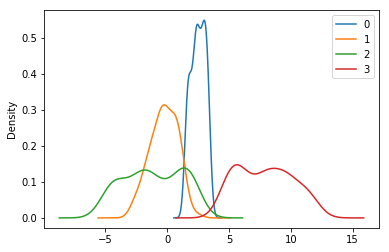

In [495]:
pd.DataFrame(test_data).plot(kind='kde');

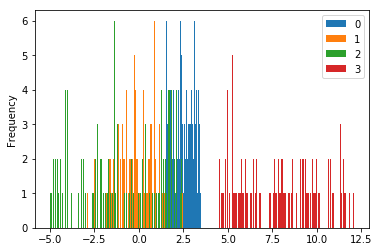

In [496]:
pd.DataFrame(test_data).plot(kind='hist', bins=300);

### StandardScaler

The most commonly used scaler—as the name indicates—is `StandardScaler`. 

This standardizes features by removing the mean and scaling to unit variance.  It loosely assumes that the underlying data is Gaussian to start with, but mostly it is fairly robust against moderate violations of that distribution.  Calculating the mean and standard deviation is per-column (as for all scalers).

In [497]:
from sklearn.preprocessing import StandardScaler
scaled1 = StandardScaler().fit_transform(test_data)
scaled1[:5]

array([[-1.69975807,  0.78714726,  1.39478736, -0.83841595],
       [-1.14333515,  0.05853659,  1.04771741, -1.5414736 ],
       [ 1.61617765,  2.46509212, -0.03687618, -0.66503836],
       [-0.31490603,  0.2935321 ,  1.1344849 ,  0.31300639],
       [ 0.03193756, -1.46541701, -0.51409736, -0.86935595]])

In [498]:
pd.DataFrame(scaled1).describe().head(3)

,0,1,2,3
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,8.104628e-16,8.659740e-17,1.908196e-17,-5.913325e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00


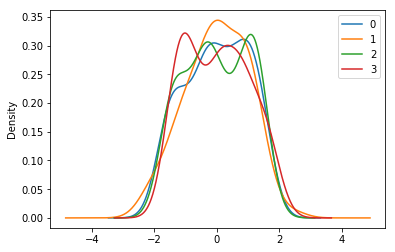

In [499]:
pd.DataFrame(scaled1).plot(kind='kde');

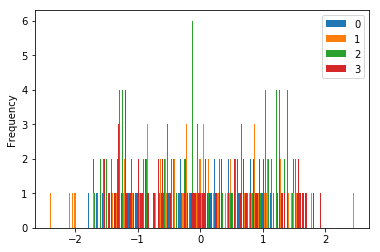

In [500]:
pd.DataFrame(scaled1).plot(kind='hist', bins=300);

### RobustScaler

This scales features using statistics that are robust to outliers. It removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [501]:
from sklearn.preprocessing import RobustScaler
scaled2 = RobustScaler().fit_transform(test_data)
scaled2[:5]

array([[-1.00675202,  0.50427064,  0.79545455, -0.48600011],
       [-0.68572979,  0.01581747,  0.61363636, -0.88236702],
       [ 0.90634151,  1.62914779,  0.04545455, -0.38825401],
       [-0.2077765 ,  0.17335607,  0.65909091,  0.16314399],
       [-0.00766881, -1.00582549, -0.20454545, -0.50344334]])

In [502]:
pd.DataFrame(scaled2).describe().head(3)

,0,1,2,3
count,100.000000,100.000000,100.000000,100.000000
mean,-0.026095,-0.023425,0.064773,-0.013321
std,0.579846,0.673767,0.526505,0.566616


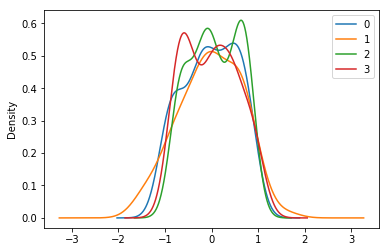

In [503]:
pd.DataFrame(scaled2).plot(kind='kde');

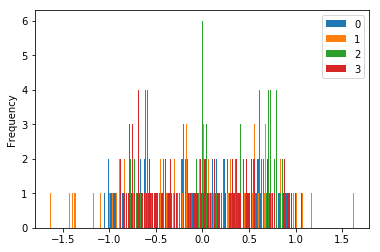

In [504]:
pd.DataFrame(scaled2).plot(kind='hist', bins=300);

### MinMaxScaler

Transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, by default between zero and one.

In [505]:
from sklearn.preprocessing import MinMaxScaler
scaled3 = MinMaxScaler().fit_transform(test_data)
scaled3[:5]

array([[0.02305307, 0.65565494, 0.95945946, 0.20265077],
       [0.18698739, 0.50613067, 0.85135135, 0.        ],
       [1.        , 1.        , 0.51351351, 0.25262548],
       [0.43106066, 0.55435606, 0.87837838, 0.53453908],
       [0.53324834, 0.19338744, 0.36486486, 0.19373256]])

In [506]:
pd.DataFrame(scaled3).describe()

,0,1,2,3
count,100.000000,100.000000,100.000000,100.000000
mean,0.523839,0.494118,0.525000,0.444317
std,0.296106,0.206252,0.313057,0.289694
min,0.000000,0.000000,0.000000,0.000000
25%,0.273950,0.359348,0.256757,0.166875
50%,0.537165,0.501289,0.486486,0.451128
75%,0.784613,0.665466,0.851351,0.678146
max,1.000000,1.000000,1.000000,1.000000


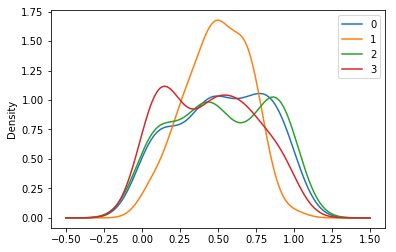

In [507]:
pd.DataFrame(scaled3).plot(kind='kde');

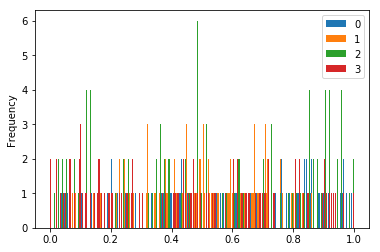

In [508]:
pd.DataFrame(scaled3).plot(kind='hist', bins=300);

### MaxAbsScaler

Scales each feature by its maximum absolute value.  This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.

In [509]:
from sklearn.preprocessing import MaxAbsScaler
scaled4 = MaxAbsScaler().fit_transform(test_data)
scaled4[:5]

array([[ 0.45267714,  0.2124029 ,  0.42      ,  0.50061126],
       [ 0.54451939, -0.06408958,  0.26      ,  0.37368882],
       [ 1.        ,  0.84914782, -0.24      ,  0.53191098],
       [ 0.68125853,  0.02508629,  0.3       ,  0.70847663],
       [ 0.73850795, -0.64239804, -0.46      ,  0.49502569]])

In [510]:
pd.DataFrame(scaled4).describe()

,0,1,2,3
count,100.000000,100.000000,100.000000,100.000000
mean,0.733236,-0.086303,-0.223000,0.651970
std,0.165890,0.381391,0.463325,0.181439
min,0.439762,-1.000000,-1.000000,0.373689
25%,0.593239,-0.335512,-0.620000,0.478205
50%,0.740702,-0.073043,-0.280000,0.656236
75%,0.879332,0.230545,0.260000,0.798419
max,1.000000,0.849148,0.480000,1.000000


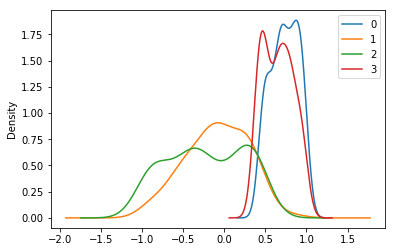

In [511]:
pd.DataFrame(scaled4).plot(kind='kde');

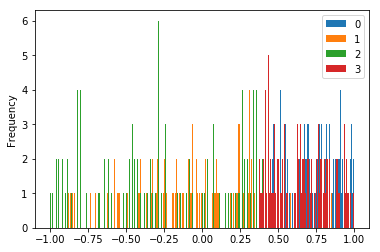

In [512]:
pd.DataFrame(scaled4).plot(kind='hist', bins=300);

### ...and others

A number of other scalers exists for special purposes.  An interesting one is `QuantileTransformer` that normalizes feature values by quantile (default `n_quantiles=1000`).  In effect this treats values in an ordinal way, eliminating any effect of outliers.  Output distributions other than the default `'uniform'` can be selected as well.

# Binning values with quantiles or binarize

In the very first example in this course, we manually binarized a target.  We decided that one of those 1-10 scale ratings would have a cut-off point for "success" versus "failure."  That sort of thing is perfectly easy to construct using Pandas predicate filters (or similarly in NumPy).  But `sklearn.preprocessing.Binarizer` is available to accomplish the same end.

In [513]:
from sklearn.preprocessing import Binarizer
binary = Binarizer(threshold=2).fit_transform(test_data)
binary[:5]

array([[0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [1., 1., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.]])

In [514]:
pd.DataFrame(binary).describe()

,0,1,2,3
count,100.000000,100.00,100.000000,100.0
mean,0.760000,0.01,0.070000,1.0
std,0.429235,0.10,0.256432,0.0
min,0.000000,0.00,0.000000,1.0
25%,1.000000,0.00,0.000000,1.0
50%,1.000000,0.00,0.000000,1.0
75%,1.000000,0.00,0.000000,1.0
max,1.000000,1.00,1.000000,1.0


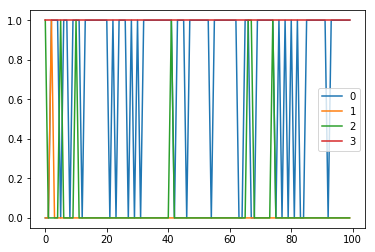

In [515]:
pd.DataFrame(binary).plot();

## Next lesson

**Pipelines**: In this lesson we dealt with quite a lot of what we might call *data engineering*. The need for feature selection, feature engineering, and scaling, goes beyond the base fact that "data always comes in messy."  Certainly the need for data cleaning is important, and has probably not been addressed to match that importance in this course.  But even data that is spotless for an data integrity and anomaly perspective (a lofty goal) might still need to be massaged to allow models to succeed in their magic.

The next lesson on pipelines will be fairly short, but very important.  We have seen a variety of ways we can manipulate data—and also ways we can tune models with hyperparameters—but we have done each of these steps one-by-one, in explicit code with extra intermediate steps lying around along the way.  Pipelines allow us to package all these steps together in one resusable API.

<a href="Pipelines.ipynb"><img src="img/open-notebook.png" align="left"/></a>